# Libraries and preparation

refs:
- https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_rag_agent_llama3_local.ipynb
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb?ref=blog.langchain.dev

Starting ollama server and pulling llama3

MAP:REDUCE: https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

In [ ]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

In [55]:
t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
t.start()

2024/07/30 10:22:02 routes.go:1099: INFO server config env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: OLLAMA_DEBUG:false OLLAMA_FLASH_ATTENTION:false OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_LLM_LIBRARY: OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:0 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://*] OLLAMA_RUNNERS_DIR: OLLAMA_SCHED_SPREAD:false OLLAMA_TMPDIR: ROCR_VISIBLE_DEVICES:]"
time=2024-07-30T10:22:02.935Z level=INFO source=images.go:784 msg="total blobs: 5"
time=2024-07-30T10:22:02.938Z level=INFO source=images.go:791 msg="total unused blobs removed: 0"
time=2024-07-30T10:22:02.

In [11]:
!ollama pull llama3.1:70b

[GIN] 2024/07/30 - 09:46:21 | 200 |    1.635549ms |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ [GIN] 2024/07/30 - 09:46:22 | 200 |  422.442786ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest ⠸ pulling manifest 
pulling aa81b541aae6... 100% ▕████████████████▏  39 GB                         
pulling 8cf247399e57... 100% ▕████████████████▏ 1.7 KB                         
pulling f1cd752815fc... 100% ▕████████████████▏  12 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B                         
pulling 3c1c2d3df5b3... 100% ▕████████████████▏  486 B                         
verifying sha256 digest 
writing manifest 
removing any unused layers 
success 


In [56]:
t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", "llama3.1:70b"]),daemon=True)
t2.start()

time=2024-07-30T10:22:09.746Z level=INFO source=payload.go:44 msg="Dynamic LLM libraries [cpu cpu_avx cpu_avx2 cuda_v11 rocm_v60102]"
time=2024-07-30T10:22:09.746Z level=INFO source=gpu.go:205 msg="looking for compatible GPUs"
time=2024-07-30T10:22:10.083Z level=INFO source=types.go:105 msg="inference compute" id=GPU-5d90b0a5-b855-b52d-822e-ab0956df5645 library=cuda compute=7.5 driver=12.4 name="Tesla T4" total="14.7 GiB" available="14.6 GiB"
time=2024-07-30T10:22:10.083Z level=INFO source=types.go:105 msg="inference compute" id=GPU-595512b3-1768-167a-5d19-d1949d8dd415 library=cuda compute=7.5 driver=12.4 name="Tesla T4" total="14.7 GiB" available="14.6 GiB"
⠙ 

[GIN] 2024/07/30 - 10:22:10 | 200 |      74.766µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/07/30 - 10:22:10 | 200 |    25.86572ms |       127.0.0.1 | POST     "/api/show"


⠹ time=2024-07-30T10:22:10.356Z level=INFO source=memory.go:309 msg="offload to cuda" layers.requested=-1 layers.model=81 layers.offload=54 layers.split=27,27 memory.available="[14.6 GiB 14.6 GiB]" memory.required.full="41.3 GiB" memory.required.partial="28.6 GiB" memory.required.kv="640.0 MiB" memory.required.allocations="[14.3 GiB 14.3 GiB]" memory.weights.total="36.5 GiB" memory.weights.repeating="35.7 GiB" memory.weights.nonrepeating="822.0 MiB" memory.graph.full="1.1 GiB" memory.graph.partial="1.1 GiB"
time=2024-07-30T10:22:10.358Z level=INFO source=server.go:383 msg="starting llama server" cmd="/tmp/ollama4288549598/runners/cuda_v11/ollama_llama_server --model /root/.ollama/models/blobs/sha256-aa81b541aae64003237a98f9f11c01e091368fda4d61ea5085bd66f83816be9f --ctx-size 2048 --batch-size 512 --embedding --log-disable --n-gpu-layers 54 --no-mmap --parallel 1 --tensor-split 27,27 --port 40139"
time=2024-07-30T10:22:10.359Z level=INFO source=sched.go:437 msg="loaded runners" count=1
t

INFO [main] build info | build=1 commit="d94c6e0" tid="138641500725248" timestamp=1722334930
INFO [main] system info | n_threads=2 n_threads_batch=-1 system_info="AVX = 1 | AVX_VNNI = 0 | AVX2 = 0 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 0 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 0 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 0 | " tid="138641500725248" timestamp=1722334930 total_threads=4
INFO [main] HTTP server listening | hostname="127.0.0.1" n_threads_http="3" port="40139" tid="138641500725248" timestamp=1722334930


llama_model_loader: - kv  22:                      tokenizer.ggml.tokens arr[str,128256]  = ["!", "\"", "#", "$", "%", "&", "'", ...
llama_model_loader: - kv  23:                  tokenizer.ggml.token_type arr[i32,128256]  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
time=2024-07-30T10:22:10.610Z level=INFO source=server.go:617 msg="waiting for server to become available" status="llm server loading model"
⠴ ⠦ llama_model_loader: - kv  24:                      tokenizer.ggml.merges arr[str,280147]  = ["Ġ Ġ", "Ġ ĠĠĠ", "ĠĠ ĠĠ", "...
llama_model_loader: - kv  25:                tokenizer.ggml.bos_token_id u32              = 128000
llama_model_loader: - kv  26:                tokenizer.ggml.eos_token_id u32              = 128009
llama_model_loader: - kv  27:                    tokenizer.chat_template str              = {% set loop_messages = messages %}{% ...
llama_model_loader: - kv  28:               general.quantization_version u32              = 2
llama_model_loader: - type  f32:  161 ten

In [5]:
%%capture --no-stderr
%pip install -U langchain-ai21 langchain-pinecone langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python nomic[local] langchain-text-splitters

[GIN] 2024/07/30 - 09:24:02 | 200 |     1.63013ms |       127.0.0.1 | HEAD     "/"
[GIN] 2024/07/30 - 09:24:02 | 200 |   44.091895ms |       127.0.0.1 | POST     "/api/show"


⠙ ⠹ ⠸ time=2024-07-30T09:24:02.855Z level=INFO source=memory.go:309 msg="offload to cuda" layers.requested=-1 layers.model=81 layers.offload=54 layers.split=27,27 memory.available="[14.6 GiB 14.6 GiB]" memory.required.full="41.3 GiB" memory.required.partial="28.6 GiB" memory.required.kv="640.0 MiB" memory.required.allocations="[14.3 GiB 14.3 GiB]" memory.weights.total="36.5 GiB" memory.weights.repeating="35.7 GiB" memory.weights.nonrepeating="822.0 MiB" memory.graph.full="1.1 GiB" memory.graph.partial="1.1 GiB"
time=2024-07-30T09:24:02.860Z level=INFO source=server.go:383 msg="starting llama server" cmd="/tmp/ollama3343306682/runners/cuda_v11/ollama_llama_server --model /root/.ollama/models/blobs/sha256-aa81b541aae64003237a98f9f11c01e091368fda4d61ea5085bd66f83816be9f --ctx-size 2048 --batch-size 512 --embedding --log-disable --n-gpu-layers 54 --no-mmap --parallel 1 --tensor-split 27,27 --port 37853"
time=2024-07-30T09:24:02.862Z level=INFO source=sched.go:437 msg="loaded runners" count

INFO [main] build info | build=1 commit="d94c6e0" tid="132429999771648" timestamp=1722331442
INFO [main] system info | n_threads=2 n_threads_batch=-1 system_info="AVX = 1 | AVX_VNNI = 0 | AVX2 = 0 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 0 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 0 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 0 | " tid="132429999771648" timestamp=1722331442 total_threads=4
INFO [main] HTTP server listening | hostname="127.0.0.1" n_threads_http="3" port="37853" tid="132429999771648" timestamp=1722331442


llama_model_loader: loaded meta data with 29 key-value pairs and 723 tensors from /root/.ollama/models/blobs/sha256-aa81b541aae64003237a98f9f11c01e091368fda4d61ea5085bd66f83816be9f (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Meta Llama 3.1 70B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Meta-Llama-3.1
llama_model_loader: - kv   5:                         general.size_label str              = 70B
llama_model_loader: - kv   6:                            general.license s

In [13]:
# choosing llm

local_llm = "llama3.1:70b"

In [7]:
# Tracing and api-keys
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["TAVILY_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["PINECONE_API_KEY"] = "94ef7896-1fae-44d3-b8d2-0bd6f5f664f5"
os.environ["AI21_API_KEY"] = "KlINkh5QKw3hG1b5Hr75YDO7TwGoQvzn"

⠸ 

# Tools

refs:
- https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/

In [26]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Indexing

Organizing external sources for the llm. Phase of indexing and chunking of docs refs:
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/
- https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/
- Nomic embeddings: https://docs.nomic.ai/atlas/capabilities/embeddings#selecting-a-device

osservazione: si possono controllare gli indici direttamente da https://app.pinecone.io/organizations/-O2Tiw_0VD7HTOASPJE5/projects/2a95c518-e514-4d39-bed8-4b12fd90ad44/indexes

In [27]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_pinecone import PineconeVectorStore
from langchain_ai21 import AI21Embeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://bmjgroup.com/celebrity-tweets-likely-shaped-us-negative-public-opinion-of-covid-19-pandemic/",
    "https://eu.usatoday.com/story/news/health/2024/07/26/covid-vaccine-us-china-propaganda/74555829007/",
    "https://www.theguardian.com/society/2023/jun/13/quarter-in-uk-believe-covid-was-a-hoax-poll-on-conspiracy-theories-finds",
]

#richiede lettura tramite pdf:
# "https://www.ourcommons.ca/Content/Committee/441/HESA/Brief/BR11822476/br-external/LutzMitchell-e.pdf"


docs = [WebBaseLoader(url).load() for url in urls] #text + meta-data on docs
docs_list = [item for sublist in docs for item in sublist] #ci serve l'attributo page_content

# Chunking
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)
index_name = "vectorstore"

# Add to vectorDB
vectorstore = PineconeVectorStore.from_documents(
    documents=doc_splits,
    #embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local", device="cuda"),
    embedding=AI21Embeddings(device="cuda"),
    index_name=index_name
)
retriever = vectorstore.as_retriever()

# Indexing KBTs

In [28]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_pinecone import PineconeVectorStore
from langchain_ai21 import AI21Embeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


# metodo che permette di creare una lista di vectorstore
def create_KBTs(aspects, urls_list: list[list[str]]):
    retriever_list = []
    index=0
    for urls in urls_list:
        docs = [WebBaseLoader(url).load() for url in urls] #text + meta-data on docs
        docs_list = [item for sublist in docs for item in sublist] #ci serve l'attributo page_content

        # Chunking
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=250, chunk_overlap=0
        )

        doc_splits = text_splitter.split_documents(docs_list)
        index_name = f"{aspects[index].lower()}-kbt"
        
        #debug:
        #print(doc_splits)

        # Add to vectorDB
        vectorstore_KBT = PineconeVectorStore.from_documents(
            documents=doc_splits,
            #embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local", device="cuda"),
            embedding=AI21Embeddings(device="cuda"),
            index_name=index_name
        )
        retriever_KBT = vectorstore_KBT.as_retriever()
        retriever_list.append(retriever_KBT)
        index=index+1
    return retriever_list

# Query generation (multi-aspects)

In [58]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You have to generate multiple
    search queries based on some specified aspects. No preamble. JSON format is expected. Here some examples:
    Original query: "What about COVID19?"
    Aspects: ["Health","Economy"]
    Answer: "Symptoms of COVID19","Economic consequences of COVID19"
    \n ----- \n
    Original query: "COVID19 was fake?"
    Aspects: ["Health","Society"]
    Answer: "Is COVID19 just a cold?","What people think about COVID19?"
    \n ----- \n
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Original query: {original_query}
    Aspects: {aspects}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["aspects","original_query"],
)

llm = ChatOllama(model=local_llm, format="json", temperature=0)

query_generator = prompt | llm | JsonOutputParser()


#original_query = "Covid19 was a hoax?"
#aspects = ["Health","Economy","Society"]
#generation = query_generator.invoke({"original_query": original_query, "aspects":aspects})
#print(list(generation.values())[0])


# # Reciprocal Rank Fusion algorithm
# def reciprocal_rank_fusion(search_results_dict, k=60):
#     fused_scores = {}
#     print("Initial individual search result ranks:")
#     for query, doc_scores in search_results_dict.items():
#         print(f"For query '{query}': {doc_scores}")

#     for query, doc_scores in search_results_dict.items():
#         for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)):
#             if doc not in fused_scores:
#                 fused_scores[doc] = 0
#             previous_score = fused_scores[doc]
#             fused_scores[doc] += 1 / (rank + k)
#             print(f"Updating score for {doc} from {previous_score} to {fused_scores[doc]} based on rank {rank} in query '{query}'")

#     reranked_results = {doc: score for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)}
#     print("Final reranked results:", reranked_results)
#     return reranked_results

[GIN] 2024/07/30 - 10:30:12 | 200 |         1m12s |       127.0.0.1 | POST     "/api/chat"
['Is COVID19 just a cold?', 'What are the economic consequences of a pandemic hoax?', 'How did society react to the idea that COVID19 was a hoax?']


# Organizing outputs

In [65]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful assistant that organizes and puts together many answers.
    Make the summary of each answer, if it is necessary, and then put them together maintaining coherence in the discussion. No preamble, just give the final output. Expected JSON format.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the answers: {answers}
    Result answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["answers"],
)

llm = ChatOllama(model=local_llm, format="json", temperature=0)

final_answer = prompt | llm | JsonOutputParser()
#final_output = final_answer.invoke({"answers": answers})
#print(final_output)

answers= ["""You didn't ask a specific question, but I can summarize the text for you.
 \n\nThe article discusses the economic impact of COVID-19 around the world. 
 It highlights that the pandemic has had significant and persistent effects on output and prices,
 especially in emerging and developing countries. The article also mentions that the partnership
 with BioNTech, high cost of production and management of the vaccine, and growing number of 
 same-size competitors have reduced investors' trust in the company to have bigger revenue 
 in 2021.\n\nThe article further notes that global coordination and cooperation are crucial for 
 slowing the spread of the pandemic and alleviating economic damage. It also emphasizes the 
 humanitarian and economic toll the global recession will take on economies with extensive 
 informal sectors, which make up an estimated one-third of GDP and about 70% of total employment 
 in emerging market and developing economies.\n\nThe article also discusses the long-term damage 
 to potential output and productivity growth, citing the June 2020 Global Economic Prospects 
 report. The report assumes that the pandemic recedes in such a way that domestic mitigation 
 measures can be lifted by mid-year in advanced economies and later in developing countries, 
 and that adverse global spillovers ease during the second half of 2020.\n\nFinally, the article 
 mentions the UN's latest World Economic Situation and Prospects report, which projects the world 
 economy to grow by 2.3% in 2023 and 2.5% in 2024, with the least developed countries forecast 
 to grow by 4.1% in 2023 and 5.2% in 2024.\n\nIf you have a specific question or would like me to 
 answer something related to this text, feel free to ask!", "It seems like you didn't provide a 
 specific question for me to answer. The text appears to be a scientific article and a brief 
 report on the impact of COVID-19 pandemic on social interactions and economic well-being.
 \n\nIf you have a specific question related to this topic, I'd be happy to help."""]

# Retrieval

In [31]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

llm = ChatOllama(model=local_llm, format="json", temperature=0) #higher temperature more likely hallucinations

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
# question = "agent memory"
# docs = retriever.invoke(question)
# doc_txt = docs[1].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

# Generating answer

In [32]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
# question = "agent memory"
# docs = retriever.invoke(question)
# generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

# Hallucinations check

Per ora non uso hallucinations check

In [33]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' (both in lower case) to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    SINGLE KEY 'score' and NO preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
#hallucination_grader.invoke({"documents": docs, "generation": generation})

# Answer check

In [34]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' (both in lower case) to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a SINGLE KEY 'score' and NO preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
#answer_grader.invoke({"question": question, "generation": generation})

# Routing

Per ora non applichiamo il routing!

In [35]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents,
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
# question = "llm agent memory"
# docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content
# print(question_router.invoke({"question": question}))

# Document check (Entailment)

In [36]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You have to perform a task of textual entailments
    between two documents. Give a binary score 'yes' or 'no' (both in lower case) to indicate whether the second document is
    entailed by the first document. Provide the binary score as a JSON with a SINGLE KEY 'score' and NO preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> The first document:
    {first_doc}
    \n ------- \n
    Entails with:
    \n ------- \n
    {second_doc}
    \n ------- \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["first_doc", "second_doc"],
)

entailment_checker = prompt | llm | JsonOutputParser()

# Control flow (Aspect agents)

refs
- https://www.langchain.com/langgraph

In [48]:
from pprint import pprint
from typing import List, Annotated
import operator
import functools

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

### State
class GraphState(TypedDict):
    """
    Represents the state of graph of aspect agents.
    """
    
    query: str
    aspect_id: int
    answers_agent: Annotated[List[str], operator.add]
    my_answer: str
    web_search: str
    documents: List[str]
    documents_kbt: List[str]


def retrieve(state,verbose):
    """
    Retrieve documents from vectorstore and from KBT

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if verbose: 
        print("---RETRIEVE---")
        print(f"State: {state}")
        
    query = state["query"]
    aspect_id = state["aspect_id"]

    # Retrieval
    documents = retriever.invoke(query)
    documents_kbt = retrievers_KBT[aspect_id].invoke(query)
    
    #pprint(f"Documents retrieved: {documents}")
    #pprint(f"Documents KBT retrieved: {documents_kbt}")
    
    return {"documents": documents, "documents_kbt": documents_kbt, "query": query}


def generate(state,verbose):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if verbose:
        print("---GENERATE---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": query})
    return {"documents": documents, "query": query, "my_answer": generation, "answers_agent": [generation]}


def grade_documents(state,verbose):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    if verbose:
        print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": query, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            if verbose: print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            if verbose: print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "query": query, "web_search": web_search}


def web_search(state,verbose):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """
    if verbose:
        print("---WEB SEARCH---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": query})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "query": query}

def entailment_filter(state):
    """
    Filter documents that doesn't entail with KBT

    Args:
        state (dict): The current graph state
    """

    print("---ENTAILMENT FILTER---")
    print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    documents_KBT = state["documents_kbt"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        for d_kbt in documents:
            score = entailment_checker.invoke(
                {"first_doc": d_kbt.page_content, "second_doc": d.page_content}
            )
            grade = score["score"]
            # Document entailed
            if grade.lower() == "yes":
                print("---DOCUMENT ENTAILED---")
                filtered_docs.append(d)
                break
    return {"documents": filtered_docs}


### Conditional edge

def route_question(state,verbose):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    if verbose:
        print("---ROUTE QUESTION---")
        print(f"State: {state}")
    query = state["query"]
    #print(queries)
    source = question_router.invoke({"question": query})
    #print(source)
    #print(source["datasource"])
    if source["datasource"] == "web_search":
        if verbose: print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        if verbose: print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state,verbose):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    if verbose:
        print("---ASSESS GRADED DOCUMENTS---")
        print(f"State: {state}")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        if verbose: print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
            )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        if verbose: print("---DECISION: GENERATE---")
        return "generate"



def grade_generation_v_documents_and_question(state,verbose):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    
    if verbose:
        print("---CHECK HALLUCINATIONS---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    my_answer = state["my_answer"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": my_answer} #answers_agent[0]
    )
    if verbose: print(f"score: {score}")
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        if verbose: print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        if verbose: print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": query, "generation": my_answer})
        grade = score["score"]
        if grade == "yes":
            if verbose: print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            if verbose: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        if verbose: pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

**Building graph with edges**

In [49]:
# Build graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", functools.partial(web_search, verbose=verbose))  # web search
workflow.add_node("retrieve", functools.partial(retrieve, verbose=verbose))  # retrieve
workflow.add_node("grade_documents", functools.partial(grade_documents, verbose=verbose))  # grade documents
workflow.add_node("generate", functools.partial(generate, verbose=verbose))  # generatae
workflow.add_node("entailment_filter", entailment_filter)  # entailment

# Non applichiamo il routing
"""
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "websearch": "websearch", #se la risposta è websearch, allora vai al nodo websearch
        "vectorstore": "retrieve", #se la risposta è vectorstore, allora vai al nodo retrieve
    },
)
"""
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    functools.partial(decide_to_generate, verbose=verbose),
    {
        "websearch": "websearch",
        "generate": "entailment_filter",
    },
)
workflow.add_edge("websearch", "entailment_filter")

workflow.add_edge("entailment_filter", "generate")

# Per ora non faccio il controllo sulle allucinazioni
workflow.add_edge("generate", END)
"""
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)
"""
    
workflow_compiled = workflow.compile()

In [50]:
#for i in range(num_aspects):
#    print(workflows[i].config_specs)

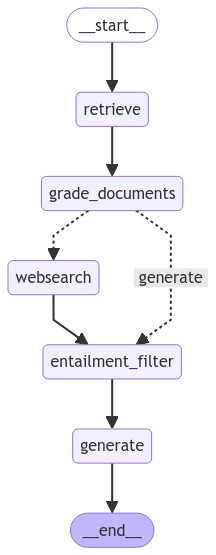

In [51]:
from IPython.display import Image, display

display(Image(workflow_compiled.get_graph().draw_mermaid_png()))

# Application

In [59]:
from typing import Annotated
import operator
from langgraph.constants import Send


### Super Graph State
class SuperGraphState(TypedDict):
    """
    Represents the state of our super-graph.
    """
    
    question: str
    aspects: List[str]
    queries: List[str]
    answers_agent: Annotated[List[str], operator.add]
    final_answer: str


def generate_queries(state,verbose):
    """
    Generate multi-aspect queries from the starting question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the multi aspect queries
    """
    if verbose: 
        print("---GENERATE MULTI-ASPECTS QUERIES---")
        print(f"State: {state}")
    question = state["question"]
    aspects = state["aspects"]

    generation = query_generator.invoke({"original_query": question, "aspects": aspects})
    #print(list(generation.values()))
    return {"queries": list(generation.values())[0]}

def send_queries(state):
    if verbose: 
        print("---SEND MULTI-ASPECTS QUERIES---")
        print(f"State: {state}")
    return [Send("aspect_agent_node", {"query": q, "aspect_id": state["queries"].index(q)}) for q in state["queries"]]

def organize_outputs(state,verbose):
    """
    Organize the outputs of the agents.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains the final answer to give to user
    """
    if verbose:
        print("---ORGANIZE OUTPUTS---")
        print(f"State: {state}")
    answers_agent = state["answers_agent"]

    final_output =final_answer.invoke({"answers": answers_agent})
    return {"final_answer": final_output}

master_flow = StateGraph(SuperGraphState)

# Define the nodes
master_flow.add_node("generate_queries", functools.partial(generate_queries, verbose=verbose))
master_flow.add_node("organize_queries", functools.partial(organize_outputs, verbose=verbose))
master_flow.add_node("aspect_agent_node",workflow_compiled)

# Build graph
master_flow.add_edge(START, "generate_queries")
master_flow.add_conditional_edges("generate_queries", send_queries, ["aspect_agent_node"])
master_flow.add_edge("aspect_agent_node", "organize_queries")
master_flow.add_edge("organize_queries", END)

app = master_flow.compile()

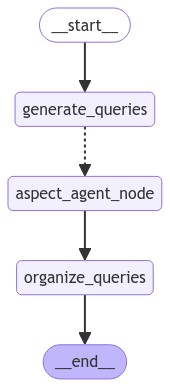

In [60]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(app.get_graph().draw_mermaid_png()))

Configurations of aspects, urls of KBTs and question

In [63]:
#aspects and urls_list must be of the same size and ordered for each aspect.
aspects = ["Health","Economy"] #["Health","Economy","Society"]
urls_list = [["https://www.who.int/emergencies/diseases/novel-coronavirus-2019/covid-19-vaccines",
             "https://www.who.int/news-room/questions-and-answers/item/vaccines-and-immunization-vaccine-safety",
             "https://www.bbc.com/news/stories-52731624",
             "https://www.bbc.com/news/technology-52903680"],
            ["https://www.worldbank.org/en/publication/wdr2022/brief/chapter-1-introduction-the-economic-impacts-of-the-covid-19-crisis"]]

retrievers_KBT = create_KBTs(aspects, urls_list)

inputs = {"question": "What about covid19?", "aspects": aspects}

#if we want print all the process: True
verbose = True 

In [64]:
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["final_answer"])

---GENERATE MULTI-ASPECTS QUERIES---
State: {'question': 'Covid19 was a hoax?', 'aspects': ['Health', 'Economy'], 'queries': None, 'answers_agent': [], 'final_answer': None}
[GIN] 2024/07/30 - 10:37:35 | 200 |         1m24s |       127.0.0.1 | POST     "/api/chat"
---SEND MULTI-ASPECTS QUERIES---
State: {'queries': ['Is COVID19 just a cold?', 'Economic impact of the COVID19 conspiracy theory'], 'question': 'Covid19 was a hoax?', 'aspects': ['Health', 'Economy'], 'answers_agent': []}
'Finished running: generate_queries:'
---RETRIEVE---
State: {'query': 'Economic impact of the COVID19 conspiracy theory', 'aspect_id': 1, 'answers_agent': [], 'my_answer': None, 'web_search': None, 'documents': None, 'documents_kbt': None}
---RETRIEVE---
State: {'query': 'Is COVID19 just a cold?', 'aspect_id': 0, 'answers_agent': [], 'my_answer': None, 'web_search': None, 'documents': None, 'documents_kbt': None}
---CHECK DOCUMENT RELEVANCE TO QUESTION---
State: {'query': 'Economic impact of the COVID19 con

time=2024-07-30T10:42:58.542Z level=WARN source=server.go:756 msg="Prompt does not specify that the LLM should response in JSON, but JSON format is expected. For best results specify that JSON is expected in the system prompt."


[GIN] 2024/07/30 - 10:44:36 | 200 |         1m37s |       127.0.0.1 | POST     "/api/chat"
'Finished running: organize_queries:'
{'answer': 'No, COVID-19 is not just a cold. While COVID-19 and the common '
           'cold share similar symptoms, there are important differences in '
           'incubation, symptoms, and how long the illness lasts. '
           'Understanding these differences can help you seek the appropriate '
           'medical care.'}
